In [1]:
from piohmm import HMM
import numpy as np
import torch
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

This notebook shows two examples of applications of PIOHMMs. 

### Create a synthetic dataset

Data is generated in the following manner. First the sequence of latent states is generated following the distributions $$z_{i,1} \sim \textrm{Cat}(\pi), \quad z_{i,t}|z_{i,t-1}=j \sim \textrm{Cat}(A_j)$$ where $i$ is the sample index and $t$ is the time index. Observations are then generated $x_{i,t} | z_{i,t}=k \sim \mathcal{N}(\mu_k, \Sigma_k)$. For each sample, a personalized offset is sampled $r_i \sim \textrm{Unif}[-b,b]$. Lastly structured noise is added to the observation $$\hat{x}_i | x_i, r_i \sim \mathcal{N}(x_i+r_i, \Sigma_T)$$ where $\Sigma_T$ is specified via a squared exponential kernel.

In [2]:
torch.manual_seed(0)

In [3]:
n = 100 #number of samples
d = 1 #dimensionality of observations
t = 20 #number of time steps
k = 2 #number of states

In [4]:
A = torch.tensor([[0.6, 0.4],[0.27, 0.73]]) #transition matrix
a_dist = torch.distributions.dirichlet.Dirichlet(3 * torch.ones(k))
pi = a_dist.sample() #inital state distributoin

mu = torch.tensor([0., 2.]) # state means
var = torch.tensor([0.1, 0.1]) #state covariance

In [5]:
b = 2 #specify the range of a uniform distribution over personalized state effects, e.g. r_i ~ Unif[-b, b]

In [6]:
X = torch.zeros((n,t,d))
Z = torch.zeros((n,t), dtype=torch.long)

for i in range(n):
    for j in range(t):
        if j == 0:
            Z[i, j] = torch.multinomial(pi, num_samples=1).byte()
            # D[i, j] = torch.rand(1)
            m_dist = torch.distributions.normal.Normal(
                mu.index_select(0, Z[i, j]),
                var.index_select(0, Z[i, j]))
            X[i, j, :] = m_dist.sample()
        else:
            Z[i, j] = torch.multinomial(A[Z[i, j - 1], :], num_samples=1)
            # D[i, j] = torch.rand(1)
            m_dist = torch.distributions.normal.Normal(
                mu.index_select(0, Z[i, j]),
                var.index_select(0, Z[i, j]))
            X[i, j, :] = m_dist.sample()

X_hat = torch.zeros(n, t, d)

l = 2.5 #lengthscale for the SE kernel
s = 4 #sigma^2 for the SE kernel

#build covariance matrix
var_x = torch.zeros(t,t)
t_vec = torch.range(0,t)
for j in range(t):
    for jj in range(t):
        r = (t_vec[j] - t_vec[jj])**2
        var_x[j, jj] = 1/s*torch.exp(-r/(2*l))

L = torch.cholesky(var_x)
b_stor = torch.zeros(n)


for i in range(n):
    e = torch.randn(t)
    b_stor[i] = 2*b*torch.rand(1) - b
    X_hat[i, :, :] =  torch.einsum('ik,k->i', [L, e])[None, :, None] + X[i, :, :] + b_stor[i]*torch.ones(1,t,1)


### Learn model

Using piohmm, two models are learned, one with personalized effects and one without (i.e. a standard HMM).

In [7]:
#fit a personalized hmm
piohmm = HMM(X_hat, k=k, full_cov=False, priorV=False, io=False, personalized=True, personalized_io=False,
                   state_io=False, UT=False, device='cpu', eps=1e-18, priorMu=True, var_fill=0.5, lr=0.005)
piohmm_params, _, _, elbo, b_hat, _  = piohmm.learn_model(num_iter=1000, intermediate_save=False)
piohmm_mps = piohmm.predict_sequence(piohmm_params, n_sample=b_hat)

piohmm_xhat = np.zeros((n,t))
piohmm_xvar = np.zeros((n,t))
for i in range(n):
    for j in range(t):
        idx = np.where(piohmm_mps[i, j].numpy() == np.arange(k))[0][0]
        piohmm_xhat[i,j] = piohmm_params['mu'][idx].numpy() + b_hat[i].detach().numpy()
        piohmm_xvar[i,j] = 2*np.sqrt(piohmm_params['var'][idx].numpy())

#fit a standard hmm
hmm = HMM(X_hat, k=k, full_cov=False, priorV=False, io=False, personalized=False, personalized_io=False,
             state_io=False, UT=False, device='cpu', eps=1e-18)
hmm_params, _, ll = hmm.learn_model(num_iter=100, intermediate_save=False)
hmm_mps = hmm.predict_sequence(hmm_params)

hmm_xhat = np.zeros((n,t))
hmm_xvar = np.zeros((n,t))
for i in range(n):
    for j in range(t):
        idx = np.where(hmm_mps[i,j].numpy() == np.arange(k))[0][0]
        hmm_xhat[i,j] = hmm_params['mu'][idx].numpy() 
        hmm_xvar[i,j] = 2*np.sqrt(hmm_params['var'][idx].numpy())

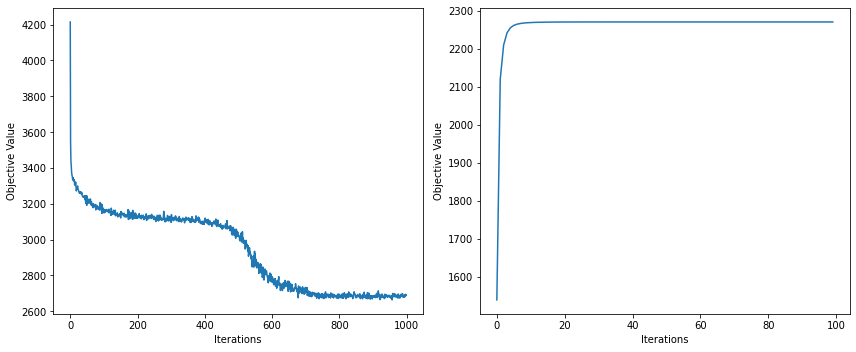

In [8]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,5)
axs[0].plot(elbo)
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Objective Value')
axs[1].plot(ll[:100])
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Objective Value')
fig.tight_layout()

### Results

The below plot shows the 'observed data' in black and the inferred mean and variance from the personalized (blue) and standard (orange) HMMs. Because the classic HMM has no way of accounting for the personalized differences, the resulting model compensates by inflating the variance.

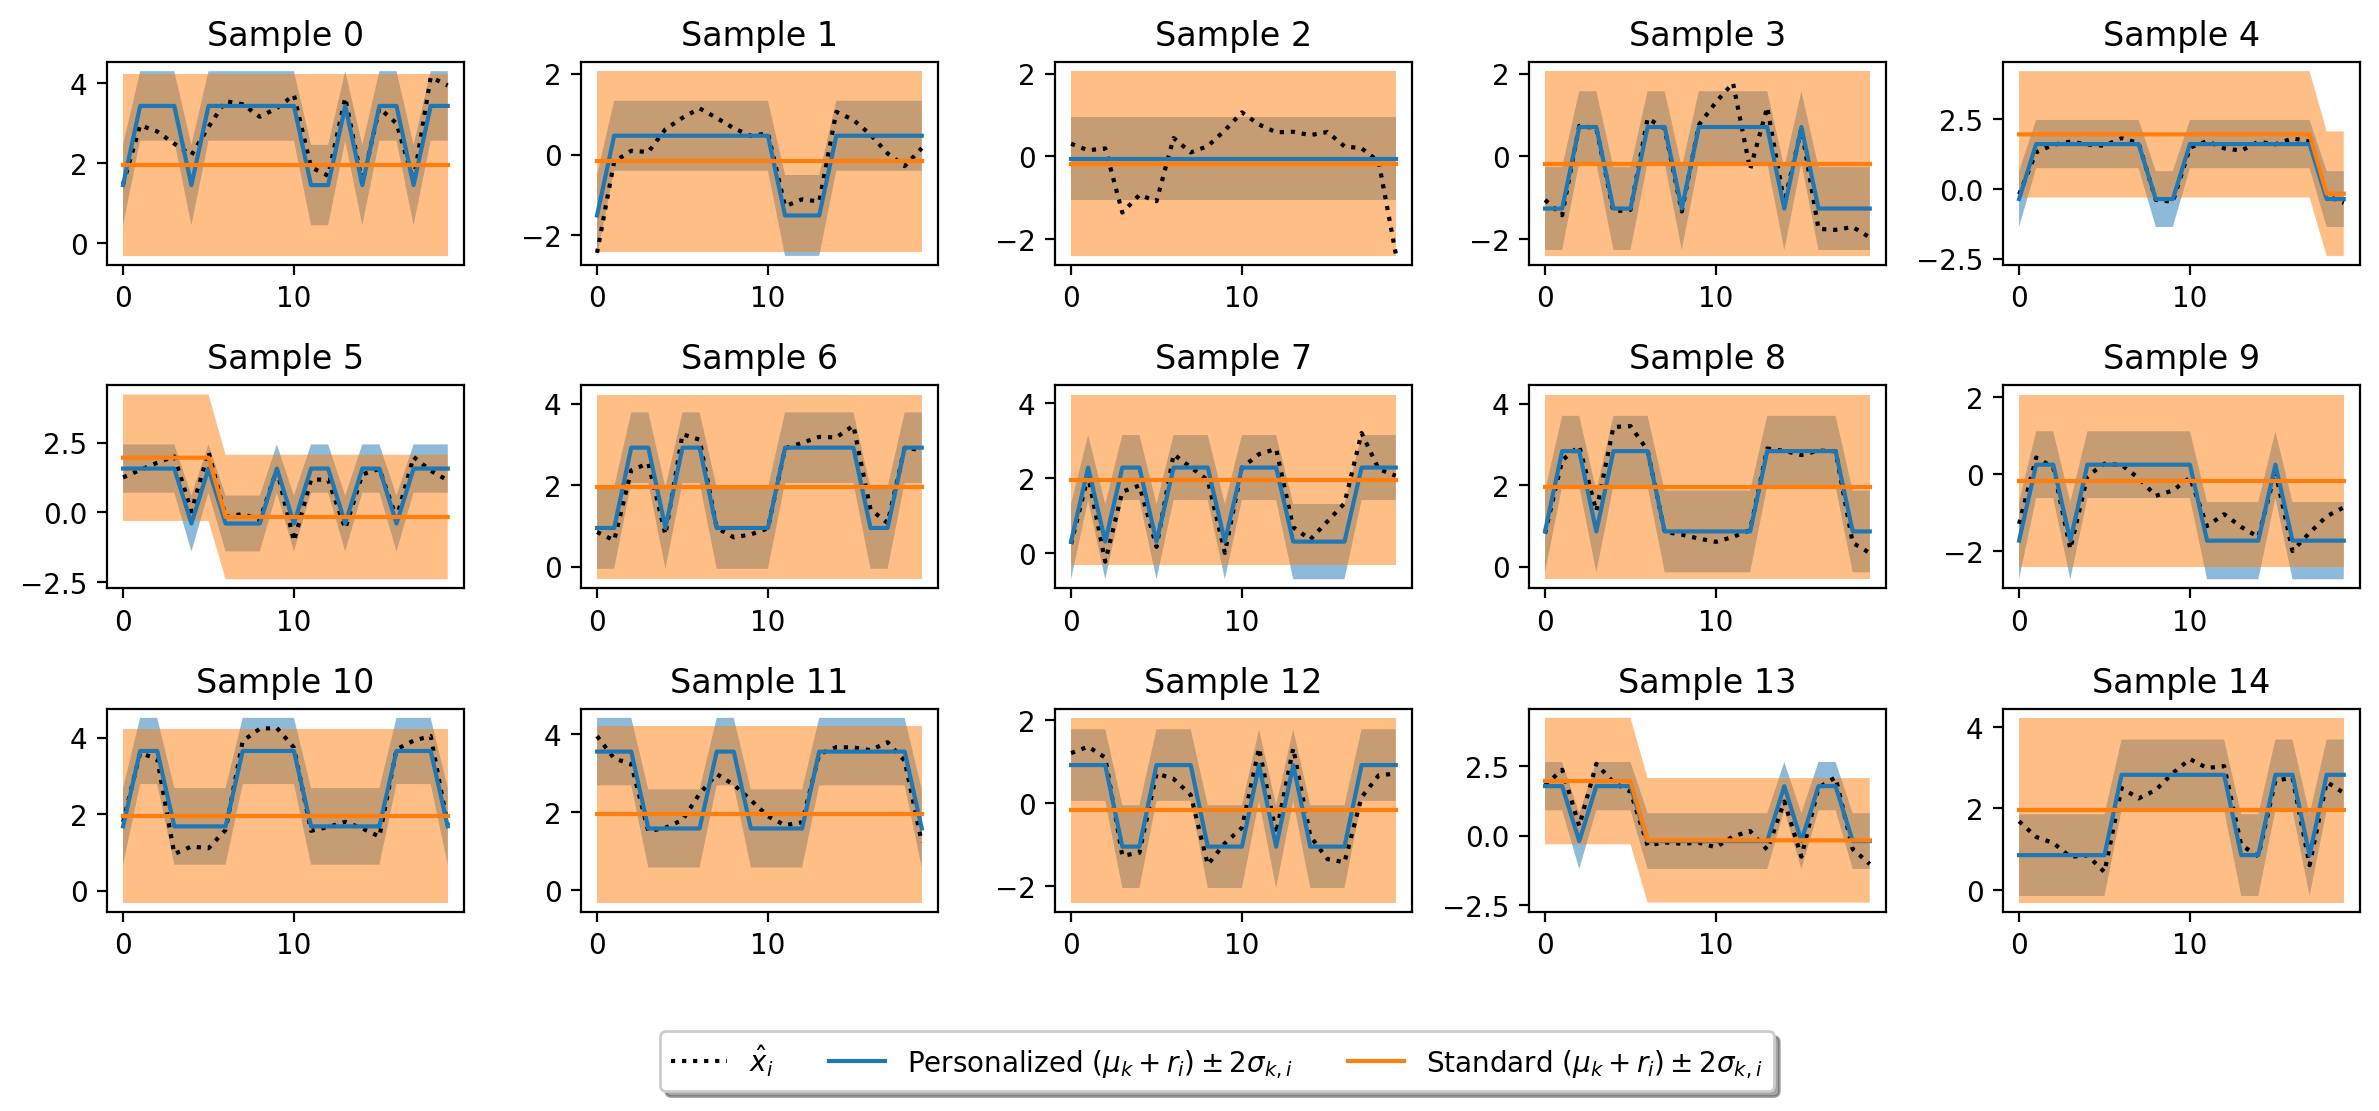

In [9]:
fig, axs = plt.subplots(3,5,dpi=200)
fig.set_size_inches(12,5)
for i, ax in enumerate(axs.flatten()):
    ax.plot(X_hat[i, :].numpy(), 'k:', label='$\hat{x}_i$')
    ax.plot(piohmm_xhat[i, :], label='Personalized $(\mu_k + r_i) \pm 2\sigma_{k,i}$')
    ax.fill_between(np.arange(t), piohmm_xhat[i,:] - piohmm_xvar[i, :], piohmm_xhat[i, :] + piohmm_xvar[i, :], alpha=0.5)
    ax.plot(hmm_xhat[i, :], label='Standard $(\mu_k + r_i) \pm 2\sigma_{k,i}$')
    ax.fill_between(np.arange(t), hmm_xhat[i,:] - hmm_xvar[i, :], hmm_xhat[i, :] + hmm_xvar[i, :], alpha=0.5)
    ax.set_title('Sample ' + str(i))
fig.tight_layout()  
ax.legend(loc='lower center', bbox_to_anchor=(-2.2, -0.95),
          fancybox=True, shadow=True, ncol=5)


The below plot shows the predicted personalized effects as compared to the inferred personalized effects. Overall, the model is successful in discovering these parameters.

(-2.5, 2.5)

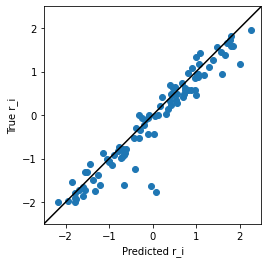

In [10]:
plt.scatter(b_hat.detach().numpy(),b_stor)
plt.plot(np.linspace(-b-0.5,b+0.5),np.linspace(-b-0.5,b+0.5),'k')
plt.axis('square')
plt.xlabel('Predicted r_i')
plt.ylabel('True r_i')
plt.xlim([-b-0.5,b+0.5])
plt.ylim([-b-0.5,b+0.5])